# **Cat Generator using GAN**

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## **Load data and create dataloader**

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
data_dir = '/kaggle/input/cats-faces-64x64-for-generative-models/cats'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [6]:
from matplotlib import pyplot as plt
import torchvision.utils as vutils
import numpy as np

def show_images(images, title="Images"):
    """
    Utility function to plot a grid of images.
    """
    # Convert images to numpy format and denormalize if needed
    if isinstance(images, torch.Tensor):
        images = images.cpu().detach()
    else:
        # If images is a list or other iterable, stack them into a tensor
        images = torch.stack(images).cpu().detach()

    # Create a grid of images
    grid_img = vutils.make_grid(images, nrow=4, padding=2, normalize=True, scale_each=True)

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid_img, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [7]:
# dataset[0][0]

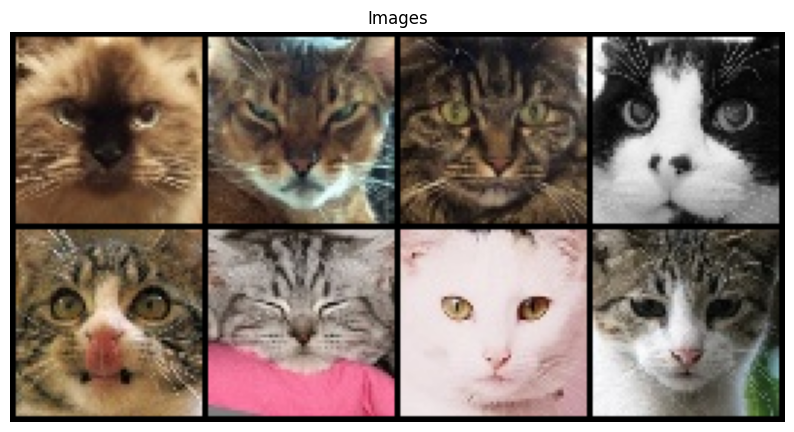

In [8]:
idx = 5
num_img = 8
show_images([dataset[i][0] for i in range(idx,idx+num_img)])

In [9]:
batch_size=128

In [10]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
images, labels = next(iter(dataloader))
print(images.shape)

torch.Size([128, 3, 64, 64])


In [12]:
dims = 64
image_channels = 3
latent_dims = 128

## **Generator**

In [13]:
class Generator(nn.Module):
  def __init__(self, dims, latent_dim=128, image_channels = 3):
    super(Generator, self).__init__()

    self.dims = dims

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, image_channels*dims*dims),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm1d(image_channels*dims*dims),
        nn.Unflatten(1, (image_channels, dims, dims))
    )

    self.up_sampling_1 = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=image_channels, out_channels=2*image_channels, kernel_size=3, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(2*image_channels)
    )

    self.up_sampling_2 = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=2*image_channels, out_channels=4*image_channels, kernel_size=3, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(4*image_channels)
    )

    self.conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=4*image_channels, out_channels=8*image_channels, kernel_size=4, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(8*image_channels)
    )

    self.conv_2 = nn.Sequential(
        nn.Conv2d(in_channels=8*image_channels, out_channels=4*image_channels, kernel_size=4, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(4*image_channels)
    )

    self.down_sampling_1 = nn.Sequential(
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=4*image_channels, out_channels=2*image_channels, kernel_size=3, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(2*image_channels)
    )

    self.down_sampling_2 = nn.Sequential(
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=2*image_channels, out_channels=image_channels, kernel_size=3, padding='same'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(image_channels)
    )

  def forward(self, x):
    x = self.linear(x)

    x = self.up_sampling_1(x)
    x = self.up_sampling_2(x)

    x = self.conv_1(x)
    x = self.conv_2(x)

    x = self.down_sampling_1(x)
    x = self.down_sampling_2(x)

    return x

In [14]:
generator = Generator(dims, latent_dims, image_channels).to(device)
print(generator)

Generator(
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=12288, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): BatchNorm1d(12288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Unflatten(dim=1, unflattened_size=(3, 64, 64))
  )
  (up_sampling_1): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sampling_2): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_1): Sequential(
    (0): Conv2d(12, 24, kernel_size=(4, 4), stride=(1, 1), padding=same)

In [15]:
gen_params = 0
for params in generator.parameters():
  gen_params+=params.numel()

print(f'Parameters: {gen_params}')

Parameters: 1620753


## **Discriminator**

In [16]:
class Discriminator(nn.Module):
  def __init__(self, dims, image_channels = 3):
    super(Discriminator, self).__init__()

    self.dims = dims

    self.up_sampling_1 = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=image_channels, out_channels=2*image_channels, kernel_size=3, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(2*image_channels)
    )

    self.up_sampling_2 = nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=2*image_channels, out_channels=4*image_channels, kernel_size=3, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(4*image_channels)
    )

    self.conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=4*image_channels, out_channels=8*image_channels, kernel_size=4, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(8*image_channels)
    )

    self.conv_2 = nn.Sequential(
        nn.Conv2d(in_channels=8*image_channels, out_channels=4*image_channels, kernel_size=4, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(4*image_channels)
    )

    self.down_sampling_1 = nn.Sequential(
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=4*image_channels, out_channels=2*image_channels, kernel_size=3, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(2*image_channels)
    )

    self.down_sampling_2 = nn.Sequential(
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=2*image_channels, out_channels=image_channels, kernel_size=3, padding='same'),
        nn.LeakyReLU(0.1, inplace=True),
        nn.BatchNorm2d(image_channels)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(image_channels*dims*dims, dims),
        nn.ReLU(),
        nn.Linear(dims, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.up_sampling_1(x)
    x = self.up_sampling_2(x)

    x = self.conv_1(x)
    x = self.conv_2(x)

    x = self.down_sampling_1(x)
    x = self.down_sampling_2(x)

    x = self.classifier(x)

    return x

In [17]:
discriminator = Discriminator(dims, image_channels).to(device)
print(discriminator)

Discriminator(
  (up_sampling_1): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up_sampling_2): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_1): Sequential(
    (0): Conv2d(12, 24, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(24, 12, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.1, inplac

In [18]:
dis_params = 0
for params in discriminator.parameters():
  dis_params+=params.numel()

print(f'Parameters: {dis_params}')

Parameters: 797586


## **Training**

In [43]:
epochs_trained = 300
print(epochs_trained)

300


In [45]:
generator = torch.load(f'/kaggle/input/can/pytorch/default/4/cat_generator_{epochs_trained}.pt')
discriminator = torch.load(f'/kaggle/input/can/pytorch/default/4/cat_discriminator_{epochs_trained}.pt')

In [46]:
epochs = (100-100)+(100-100)+(100-100)+(100)
learning_rate = 2e-4
# k = 16

In [22]:
from tqdm.notebook import trange, tqdm
from torch.optim import Adam

def train(generator, discriminator, epochs, learning_rate, dataloader, batch_size, epochs_trained):

  criterion = nn.BCELoss()
  optimizer_g = Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
  optimizer_d = Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

  real_label = 1.0
  fake_label = 0.0

  history_g = []
  history_d_real = []
  history_d_fake = []

  for epoch in trange(epochs, desc='Training'):
    for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
      #  Train discriminator -> Max ((log(D(data))) + (log(1 - D(G(noise)))))
      # print(torch.tensor(real_images).shape)
      real_images, _ = batch
      real_images = real_images.to(device)

      #  Real data
      optimizer_d.zero_grad()
      labels_real = torch.full((real_images.shape[0],), real_label, dtype=torch.float32, device=device)

      outputs_real = discriminator(real_images).view(-1)
      loss_d_real = criterion(outputs_real, labels_real)
      loss_d_real.backward()


      #  Fake data
      noise = torch.randn(real_images.shape[0], latent_dims, device=device)
      fake_images = generator(noise)
      labels_fake = torch.full((real_images.shape[0],), fake_label, dtype=torch.float32, device=device)

      outputs_fake = discriminator(fake_images.detach()).view(-1)
      loss_d_fake = criterion(outputs_fake, labels_fake)
      loss_d_fake.backward()

      optimizer_d.step()

      #  Train generator -> Min (log(1 - D(G(noise))))
      optimizer_g.zero_grad()

      labels_fake.fill_(real_label)

      output_fake = discriminator(fake_images).view(-1)
      loss_g = criterion(output_fake, labels_fake)
      loss_g.backward()


      optimizer_g.step()

    epochs_trained += 1
    if epochs_trained % 25 == 0:
        generator_path = f'cat_generator_{epochs_trained}.pt'
        discriminator_path = f'cat_discriminator_{epochs_trained}.pt'

        torch.save(generator, generator_path)
        torch.save(discriminator, discriminator_path)
    
    history_d_real.append(loss_d_real.item())
    history_d_fake.append(loss_d_fake.item())
    history_g.append(loss_g.item())

  return history_g, history_d_real, history_d_fake, epochs_trained

In [23]:
history = [
    [],
    [],
    []
  ]

In [47]:
history_g, history_d_real, history_d_fake, epochs_trained = train(generator, discriminator, epochs, learning_rate, dataloader, batch_size, epochs_trained)

history[0].extend(history_g)
history[1].extend(history_d_real)
history[2].extend(history_d_fake)

plt.plot(history[0], label='Generator')
plt.plot(history[1], label='Discriminator Real')
plt.plot(history[2], label='Discriminator Fake')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/124 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
generator_path = f'cat_generator_{epochs_trained}.pt'
discriminator_path = f'cat_discriminator_{epochs_trained}.pt'

torch.save(generator, generator_path)
torch.save(discriminator, discriminator_path)


from IPython.display import FileLink
FileLink(generator_path)
FileLink(discriminator_path)

In [48]:
def visualize_generated_images(generator, latent_dim=128, num_images=64, device='cpu'):
    """
    Visualizes a batch of images generated by the generator.
    """
    # Generate noise
    noise = torch.randn(num_images, latent_dim, device=device)

    # Generate images
    with torch.no_grad():
        generated_images = generator(noise)

    print(torch.tensor(generated_images).shape)

    # Show images
    show_images(generated_images, title="Generated Images")

/tmp/ipykernel_34/1401780418.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(generated_images).shape)


torch.Size([8, 3, 64, 64])


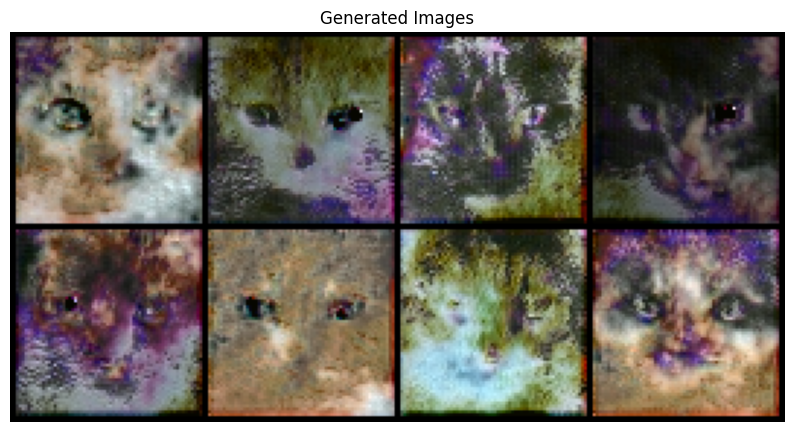

In [54]:
visualize_generated_images(generator, latent_dims, 8, device)